In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cat_mod.models.hmm import HMMFitter
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import multinomial_proportions_confint

In [2]:
def prepare_data(path, drop_cols, drop_rows, sheet):
    df = pd.read_excel('data/seuqeunces_final_11_06_25.xlsx', sheet_name=sheet)
    df = df.drop(drop_cols, axis=1).drop(drop_rows, axis=0)
    return df.iloc[:, :80], df.iloc[:, 80:]

def map_colours(data, nan=-1, min_count=0):
    colours = data.stack().value_counts()
    col_to_numb = dict()
    for i, col in enumerate(colours.index):
        if colours.loc[col] > min_count:
            col_to_numb[col] = i
        else:
            col_to_numb[col] = nan
    data.replace(col_to_numb, inplace=True)
    data.fillna(nan, inplace=True)
    return data, col_to_numb, colours

# No red train

In [3]:
no_red1_train, no_red1_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 1, 3, 4], sheet=0)
no_red2_train, no_red2_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 5], sheet=2)
no_red_train = pd.concat([no_red1_train, no_red2_train]).reset_index(drop=True)
no_red_train_num, color_to_num, freqs = map_colours(no_red_train, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 7}
0             1882
желтая         241
золотая        129
белая           97
синяя           82
зеленая         28
черная          17
серебряная       1
Name: count, dtype: int64


/tmp/ipykernel_10631/594870669.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [48]:
# seeds = np.random.randint(10000, size=10)
seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=1000,
    tol=0.01,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [49]:
X = no_red_train.to_numpy().astype(np.int32)

In [65]:
model = HMMFitter(X)
scores = model.fit_model(
    **conf
)

Total data points: 2480, obs states: 8


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.92it/s]

Components f1, total parameters: 9
Components f2, total parameters: 20


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:09<00:15,  5.30s/it]

Components f3, total parameters: 33


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:22<00:18,  9.23s/it]

Components f4, total parameters: 48


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [00:44<00:14, 14.12s/it]

Components f5, total parameters: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.70s/it]


In [66]:
model.scores.groupby(model.scores['n_comp']).agg(['mean', 'std'])

seed                  score                 aic                 bic  \
          mean          std      mean       std      mean       std      mean   
n_comp                                                                          
1       3800.3  2965.362899 -0.916260  0.000000  1.838166  0.000000  1.854582   
2       3800.3  2965.362899 -0.895063  0.021865  1.803836  0.043731  1.843704   
3       3800.3  2965.362899 -0.866877  0.000722  1.757141  0.001444  1.825151   
4       3800.3  2965.362899 -0.865101  0.015367  1.764880  0.030734  1.865722   
5       3800.3  2965.362899 -0.856830  0.004452  1.761241  0.008904  1.899606   

                  
             std  
n_comp            
1       0.000000  
2       0.043731  
3       0.001444  
4       0.030734  
5       0.008904

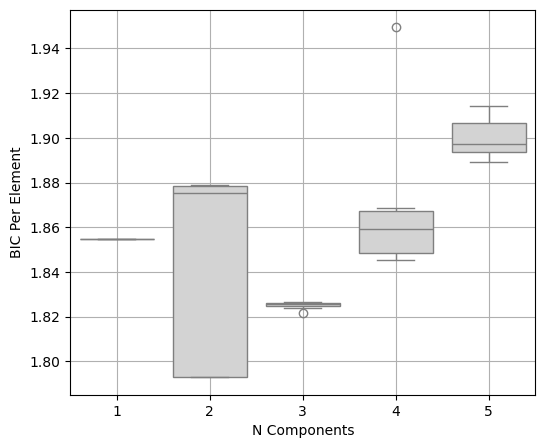

In [67]:
fig, ax = plt.subplots(figsize=(6, 5))
#sns.lineplot(shuffled.scores, x='n_comp', y='bic', ax=ax, label='shuffled')
sns.boxplot(model.scores, x='n_comp', y='bic', ax=ax, color='lightgray')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_no_red_train.png')

In [68]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black', 'silver']

In [69]:
def ordering_states_by_prior(model):
    column_order = np.argsort(-model.startprob_)
    model.startprob_ = model.startprob_[column_order]
    model.transmat_ = model.transmat_[:, column_order]
    model.transmat_ = model.transmat_[column_order, :]
    model.emissionprob_ = model.emissionprob_[column_order, :]

In [70]:
ordering_states_by_prior(model.model)
prior = model.model.startprob_[None].copy()
trans = model.model.transmat_.copy()
emission = model.model.emissionprob_.copy()

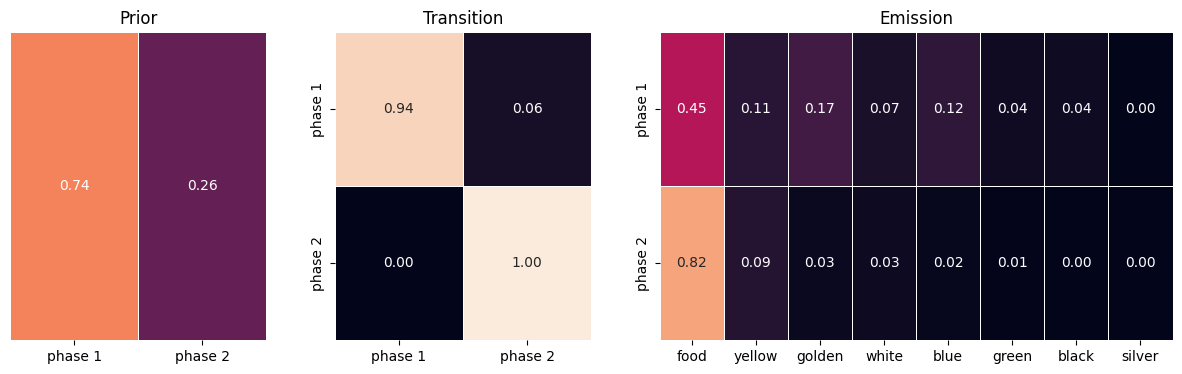

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='0.2f'
)
sns.heatmap(prior, ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
sns.heatmap(trans, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
ax[1].set_yticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
sns.heatmap(emission, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red_train_best.png')

In [27]:
conf['n_components'] = [3]
model_3comp = HMMFitter(X)
scores = model_3comp.fit_model(
    **conf
)

Total data points: 2480, obs states: 8


  0%|                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

Components f3, total parameters: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


In [72]:
ordering_states_by_prior(model_3comp.model)
prior = model_3comp.model.startprob_[None].copy()
trans = model_3comp.model.transmat_.copy()
emission = model_3comp.model.emissionprob_.copy()

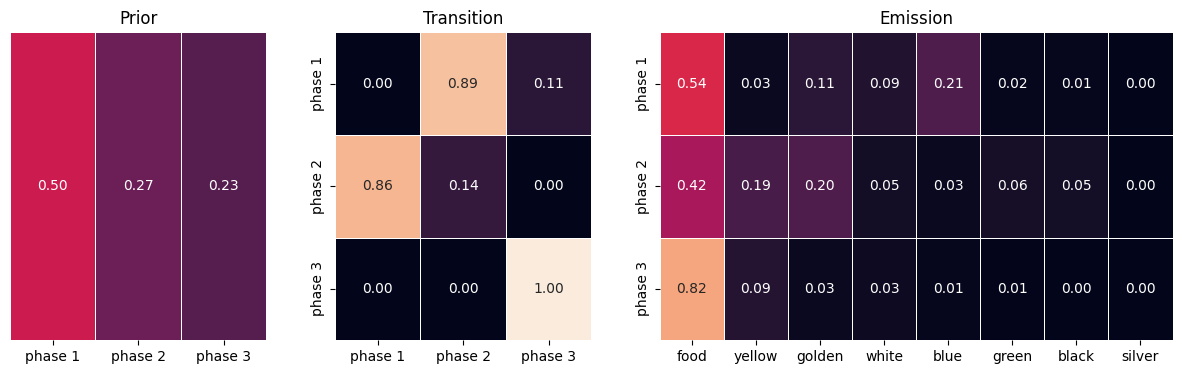

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='0.2f'
)
sns.heatmap(prior, ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(trans, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[1].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(emission, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red_train_3comp.png')

In [117]:
# add bars with frequency realtions
# 1. decode sequences
# 2. split them in two phases
# 3. compute average frequences over phases for all sequnces

In [74]:
model.model.algorithm='map'

In [75]:
likelihood, X_decoded = model.model.decode(X.flatten()[:, None], lengths=[X.shape[1]] * X.shape[0])

In [76]:
X_decoded = X_decoded.reshape(X.shape)

In [98]:
freqs_pre = np.zeros(model.model.n_features)
freqs_post = np.zeros(model.model.n_features)
freqs_pre_inds = list()
freqs_post_inds = list()
for dec_seq, seq in zip(X_decoded, X):
    clrs_pre, counts_pre = np.unique(seq[~dec_seq.astype(np.bool)], return_counts=True)
    freqs_pre_ind = np.zeros_like(freqs_pre)
    freqs_pre_ind[clrs_pre] = counts_pre
    freqs_pre_inds.append(freqs_pre_ind / (counts_pre.sum() + 1e-25))
    freqs_pre[clrs_pre] += counts_pre
    
    clrs_post, counts_post = np.unique(seq[dec_seq.astype(np.bool)], return_counts=True)
    freqs_post_ind = np.zeros_like(freqs_post)
    freqs_post_ind[clrs_post] = counts_post
    freqs_post_inds.append(freqs_post_ind / (counts_post.sum() + 1e-25))
    freqs_post[clrs_post] += counts_post

In [99]:
intervals_pre = multinomial_proportions_confint(freqs_pre, method='goodman')
print(intervals_pre)

[[0.35086971 0.48829051]
 [0.0807335  0.17213977]
 [0.13454749 0.2428469 ]
 [0.04092109 0.11337296]
 [0.08948482 0.18414198]
 [0.02179334 0.08061691]
 [0.01999517 0.0772267 ]
 [0.         0.01939617]]


In [100]:
intervals_post = multinomial_proportions_confint(freqs_post, method='goodman')
print(intervals_post)

[[7.97637269e-01 8.43279956e-01]
 [7.73151204e-02 1.12057324e-01]
 [2.01616087e-02 4.02689086e-02]
 [2.45483521e-02 4.63112917e-02]
 [9.81869019e-03 2.50130622e-02]
 [2.64539736e-03 1.22762046e-02]
 [1.71195693e-04 5.26938218e-03]
 [5.07742124e-05 4.44170126e-03]]


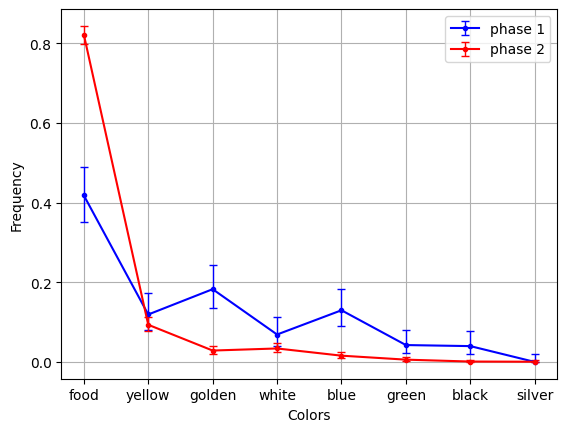

In [101]:
freqs_pre /= freqs_pre.sum()
freqs_post /= freqs_post.sum()
x = np.arange(freqs_pre.size)
ecfg = dict(capsize=3, elinewidth=1, capthick=1, fmt='.-')
plt.errorbar(x, freqs_pre, yerr=np.array([(f-ci[0], ci[1]-f) for f, ci in zip(freqs_pre, intervals_pre)]).T, label='phase 1', color='b', **ecfg)
plt.errorbar(x, freqs_post, yerr=np.array([(f-ci[0], ci[1]-f) for f, ci in zip(freqs_post, intervals_post)]).T, label='phase 2', color='r', **ecfg)
plt.legend()
plt.grid()
plt.xticks(ticks=x, labels=y_labels)
plt.xlabel('Colors')
plt.ylabel('Frequency')
plt.savefig('no_red_train_freqs.png')

In [102]:
freqs_pre_inds = np.vstack(freqs_pre_inds)
freqs_post_inds = np.vstack(freqs_post_inds)

In [103]:
tttest_restuls_no_red = dict()

In [105]:
freqs_pre_inds.mean(axis=0)

array([0.25216844, 0.08207842, 0.12453816, 0.0426603 , 0.10329697,
       0.05014919, 0.02252788, 0.        ])

In [106]:
freqs_post_inds.mean(axis=0)

array([8.22148036e-01, 8.98312284e-02, 2.85670487e-02, 3.43932108e-02,
       1.75087892e-02, 6.17416543e-03, 9.29492323e-04, 4.48028674e-04])

In [108]:
pvalues = ttest_ind(freqs_pre_inds, freqs_post_inds, equal_var=False).pvalue

In [112]:
pd.DataFrame({color: [pval] for color, pval in zip(y_labels, pvalues)})

,food,yellow,golden,white,blue,green,black,silver
0,2.441379e-14,0.74975,0.00036,0.608744,0.006191,0.016169,0.013483,0.325309


# No red, no food

In [58]:
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = [32, 432, 333, 4324, 86958],
    # n_components = [2],
    # seeds = [42],
    max_iter=1000,
    tol=0.01,
    filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [59]:
model_no_food = HMMFitter(X)
scores = model_no_food.fit_model(
    **conf
)

Total data points: 594, obs states: 6


  0%|                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 7
Components f2, total parameters: 16


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:03<00:05,  1.88s/it]

Components f3, total parameters: 27


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:09<00:06,  3.36s/it]

Components f4, total parameters: 40


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [00:15<00:04,  4.38s/it]

Components f5, total parameters: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.45s/it]


In [60]:
model_no_food.scores.groupby(model_no_food.scores['n_comp']).agg(['mean', 'std'])

seed                   score                 aic            \
           mean           std      mean       std      mean       std   
n_comp                                                                  
1       18415.8  38356.814352 -1.512610  0.000000  3.042054  0.000000   
2       18415.8  38356.814352 -1.468494  0.028258  2.980760  0.056516   
3       18415.8  38356.814352 -1.447152  0.025759  2.971744  0.051518   
4       18415.8  38356.814352 -1.413870  0.010035  2.945586  0.020070   
5       18415.8  38356.814352 -1.405673  0.016536  2.976329  0.033072   

             bic            
            mean       std  
n_comp                      
1       3.078981  0.000000  
2       3.076769  0.056516  
3       3.141607  0.051518  
4       3.204072  0.020070  
5       3.338210  0.033072

In [61]:
shuffled_no_food = HMMFitter(X_shuffled)
scores_shuffled = shuffled_no_food.fit_model(
    **conf
)

Total data points: 594, obs states: 6


  0%|                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 7
Components f2, total parameters: 16


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:03<00:04,  1.57s/it]

Components f3, total parameters: 27


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:06<00:05,  2.51s/it]

Components f4, total parameters: 40


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [00:12<00:03,  3.66s/it]

Components f5, total parameters: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


In [56]:
shuffled_no_food.scores.groupby('n_comp').agg(['mean', 'std'])

seed                   score                 aic            \
           mean           std      mean       std      mean       std   
n_comp                                                                  
1       18415.8  38356.814352 -1.512610  0.000000  3.042054  0.000000   
2       18415.8  38356.814352 -1.482738  0.014409  3.009247  0.028818   
3       18415.8  38356.814352 -1.486026  0.018328  3.049493  0.036657   
4       18415.8  38356.814352 -1.458900  0.010931  3.035645  0.021863   
5       18415.8  38356.814352 -1.433069  0.009664  3.031122  0.019328   
7       18415.8  38356.814352 -1.431972  0.008739  3.143406  0.017478   
10      18415.8  38356.814352 -1.393052  0.016912  3.287787  0.033824   

             bic            
            mean       std  
n_comp                      
1       3.078981  0.000000  
2       3.105256  0.028818  
3       3.219355  0.036657  
4       3.294131  0.021863  
5       3.393003  0.019328  
7       3.756387  0.017478  
10      4.388199  0.033824

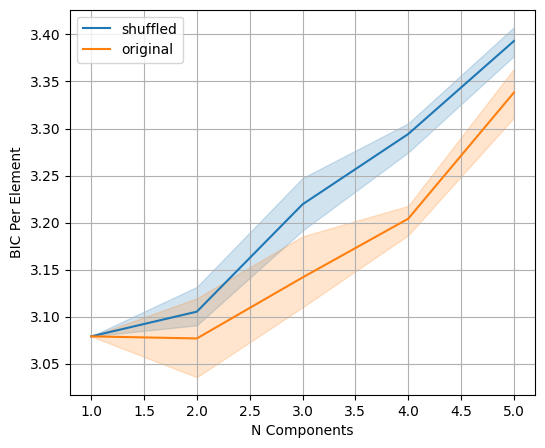

In [62]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(shuffled_no_food.scores, x='n_comp', y='bic', ax=ax, label='shuffled')
sns.lineplot(model_no_food.scores, x='n_comp', y='bic', ax=ax, label='original')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_no_red_train_no_food.png')

In [68]:
conf['n_components'] = [2]
conf['seeds'] = [243, 42, 234, 1124, 44980]
model_no_food = HMMFitter(X)
scores = model_no_food.fit_model(
    **conf
)

Total data points: 594, obs states: 6


  0%|                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

Components f2, total parameters: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


In [63]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black']

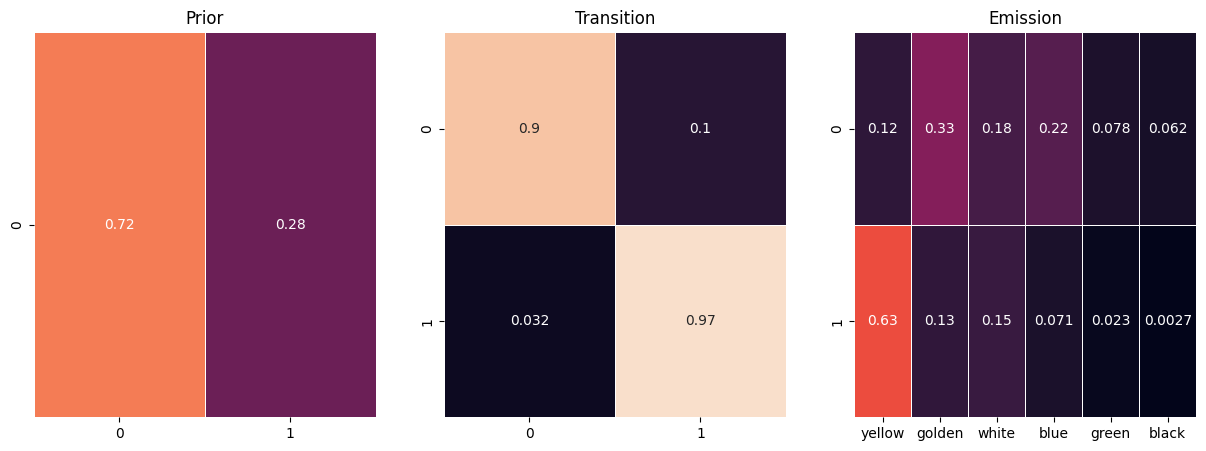

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(model_no_food.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
sns.heatmap(model_no_food.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
sns.heatmap(model_no_food.model.emissionprob_, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_xticklabels(y_labels[1:])
plt.savefig('matrices_no_food.png')

In [66]:
conf['n_components'] = [2]
shuffled_no_food = HMMFitter(X_shuffled)
scores_shuffled = shuffled_no_food.fit_model(
    **conf
)

Total data points: 594, obs states: 6


  0%|                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

Components f2, total parameters: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


[Text(0.5, 0, 'yellow'),
 Text(1.5, 0, 'golden'),
 Text(2.5, 0, 'white'),
 Text(3.5, 0, 'blue'),
 Text(4.5, 0, 'green'),
 Text(5.5, 0, 'black')]

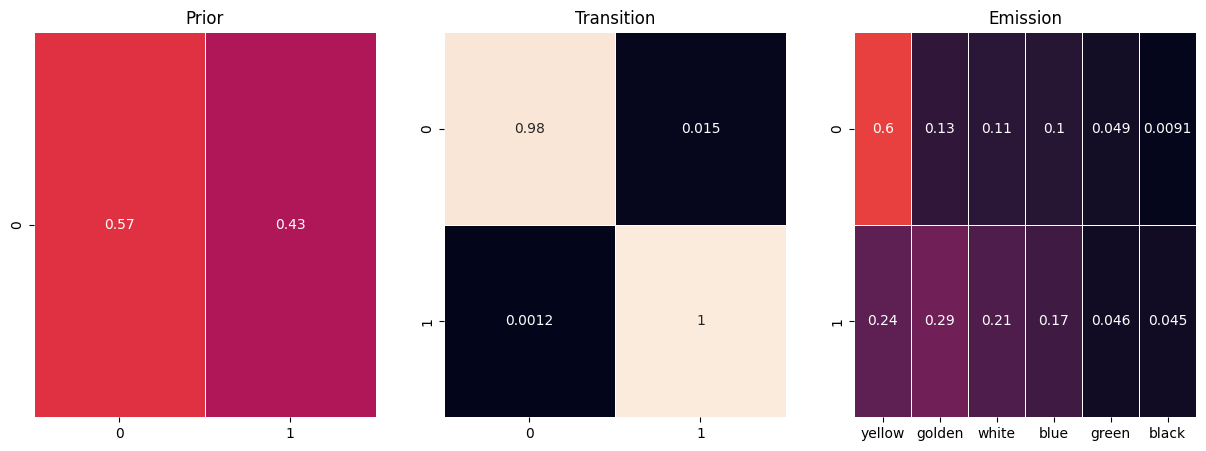

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(shuffled_no_food.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
sns.heatmap(shuffled_no_food.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
sns.heatmap(shuffled_no_food.model.emissionprob_, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_xticklabels(y_labels[1:])

# Separate groups

In [118]:
# add ttest for red for test between no red -> red and red -> red

## no red -> no red

In [119]:
no_red1_train, no_red1_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 1, 3, 4], sheet=0)
no_red1 = pd.concat([no_red1_train, no_red1_test]).reset_index(drop=True)
no_red1_num, color_to_num, freqs = map_colours(no_red1, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 7}
0             1478
желтая         150
золотая         67
белая           52
синяя           42
зеленая         13
черная          13
серебряная       1
Name: count, dtype: int64


/tmp/ipykernel_10631/594870669.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [120]:
X = no_red1_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_merged = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_merged[:, :80] = X[:, :80]
X_merged[:, 81:] = X[:, 80:]
X_merged[:, 80] = trans_color

X_train, X_test = X[:, :80], X[:, 80:]

In [121]:
# seeds = np.random.randint(10000, size=10)
seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=1000,
    tol=0.01,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

### Merged

In [124]:
model_no_red1_merged = HMMFitter(X_merged)
scores = model_no_red1_merged.fit_model(
    **conf
)

Total data points: 3666, obs states: 9


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.48it/s]

Components f1, total parameters: 10
Components f2, total parameters: 22


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:09<00:16,  5.53s/it]

Components f3, total parameters: 36


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:20<00:15,  7.98s/it]

Components f4, total parameters: 52


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [00:52<00:17, 17.52s/it]

Components f5, total parameters: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:28<00:00, 17.66s/it]


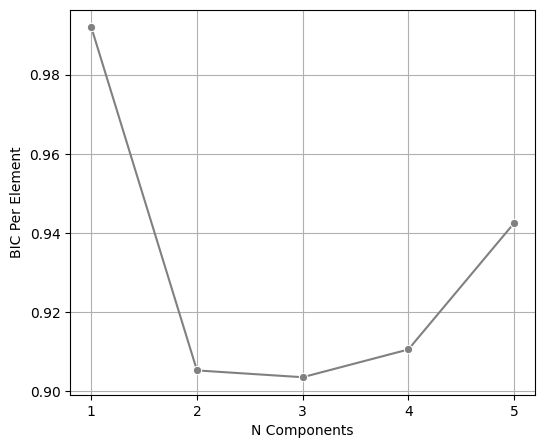

In [141]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(model_no_red1_merged.scores, x='n_comp', y='bic', ax=ax, 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
ax.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_no_red1.png')

In [142]:
ordering_states_by_prior(model_no_red1_merged.model)
prior = model_no_red1_merged.model.startprob_[None].copy()
trans = model_no_red1_merged.model.transmat_.copy()
emission = model_no_red1_merged.model.emissionprob_.copy()

In [143]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 7}

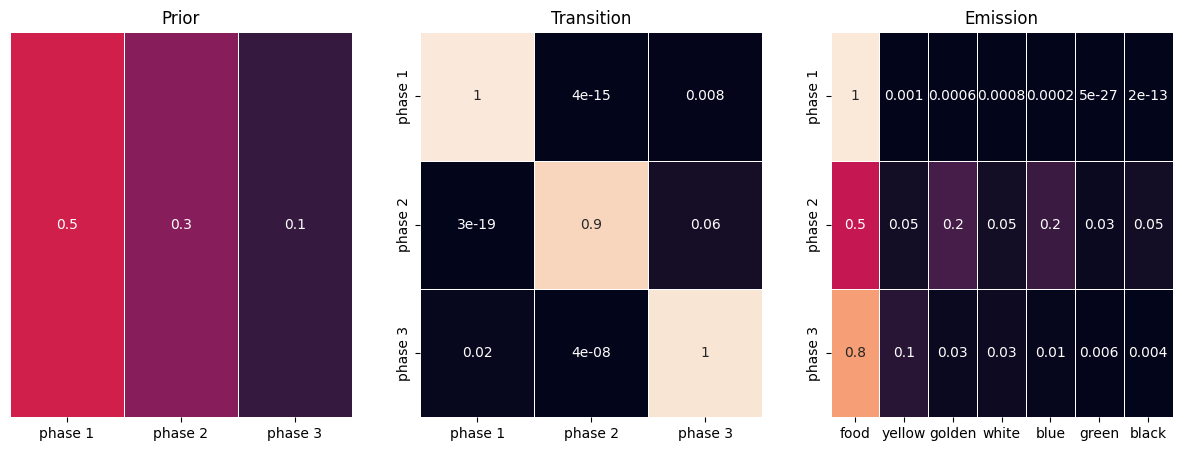

In [146]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='.1g'
)
sns.heatmap(prior, ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(trans, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[1].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(emission[:, :-2], ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red_best.png')

In [72]:
no_red2_train, no_red2_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 5], sheet=2)
no_red2 = pd.concat([no_red2_train, no_red2_test]).reset_index(drop=True)
no_red2_num, color_to_num, freqs = map_colours(no_red2, min_count=3, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 0, 'красная': 0}
0             2102
желтая         177
золотая         86
белая           71
синяя           47
зеленая         22
черная           8
серебряная       3
красная          3
Name: count, dtype: int64


/tmp/ipykernel_10403/594870669.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [73]:
X = no_red2_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_num = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_num[:, :80] = X[:, :80]
X_num[:, 81:] = X[:, 80:]
X_num[:, 80] = trans_color

In [74]:
model_no_red2 = HMMFitter(X_num)
scores = model_no_red2.fit_model(
    **conf
)

Total data points: 5076, obs states: 8


  0%|                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 9


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.02it/s]

Components f2, total parameters: 20


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:08<00:15,  5.15s/it]

Components f3, total parameters: 33


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:27<00:22, 11.12s/it]

Components f4, total parameters: 48


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [01:00<00:19, 19.95s/it]

Components f5, total parameters: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.95s/it]


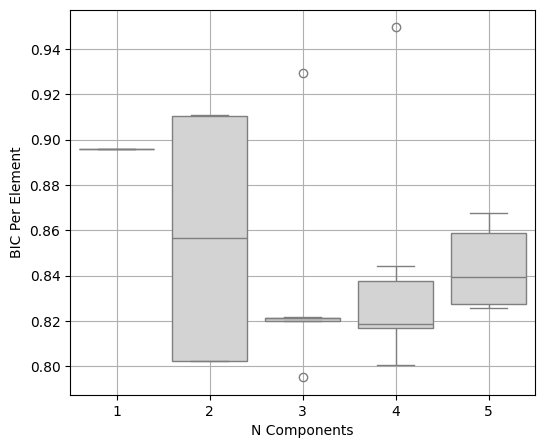

In [75]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(model_no_red2.scores, x='n_comp', y='bic', ax=ax, color='lightgray')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_no_red2.png')

In [76]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 0,
 'красная': 0}

In [80]:
a = np.arange(9).reshape(3, 3)

In [81]:
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

AxisError: axis 2 is out of bounds for array of dimension 2

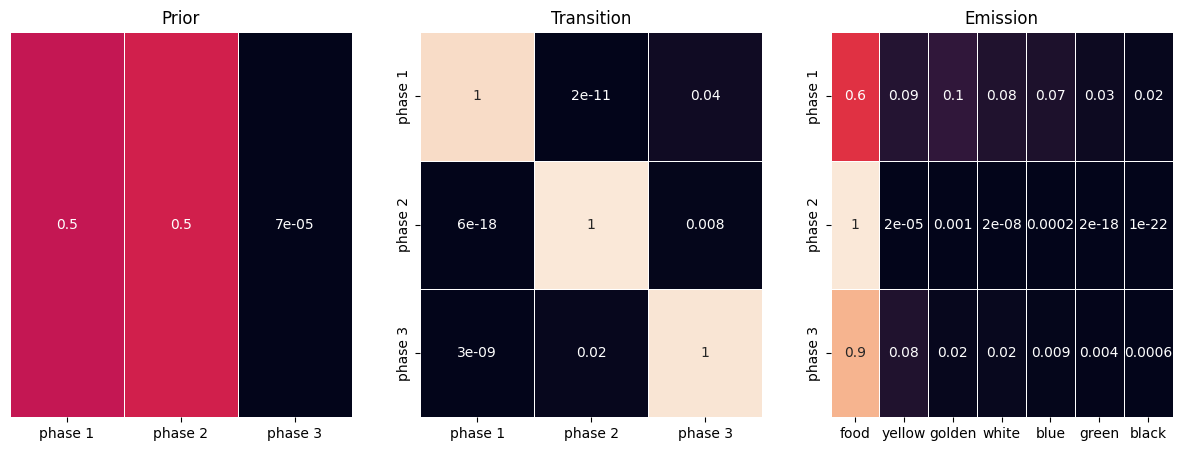

In [77]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='.1g'
)
sns.heatmap(model_no_red2.model.startprob_.[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(model_no_red2.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[1].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(model_no_red2.model.emissionprob_[:, :-1], ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red2_best.png')

## red

In [84]:
red_train, red_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [], sheet=1)
red = pd.concat([red_train, red_test]).reset_index(drop=True)
red_num, color_to_num, freqs = map_colours(red, min_count=3, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'белая': 2, 'золотая': 3, 'синяя': 4, 'красная': 5, 'зеленая': 6, 'черная': 7, 'серебряная': 0, 'золотая ': 0}
0             2283
желтая         193
белая           62
золотая         38
синяя           32
красная         23
зеленая         15
черная           8
серебряная       2
золотая          1
Name: count, dtype: int64


/tmp/ipykernel_10403/594870669.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [85]:
X = red_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_num = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_num[:, :80] = X[:, :80]
X_num[:, 81:] = X[:, 80:]
X_num[:, 80] = trans_color

In [86]:
model_red = HMMFitter(X_num)
scores = model_red.fit_model(
    **conf
)

Total data points: 5358, obs states: 9


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.64it/s]

Components f1, total parameters: 10
Components f2, total parameters: 22


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:10<00:17,  5.90s/it]

Components f3, total parameters: 36


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:27<00:22, 11.12s/it]

Components f4, total parameters: 52


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [01:08<00:23, 23.09s/it]

Components f5, total parameters: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.02s/it]


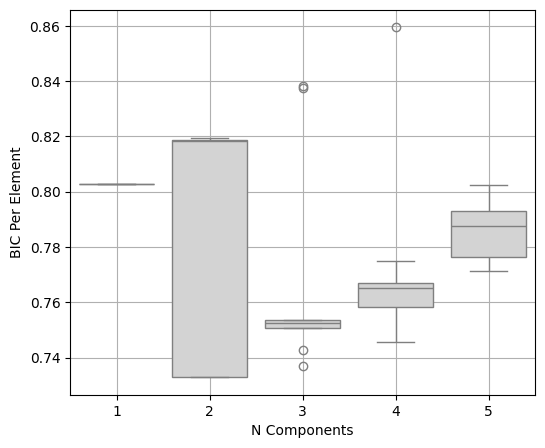

In [87]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(model_red.scores, x='n_comp', y='bic', ax=ax, color='lightgray')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_red.png')

In [88]:
color_to_num

{0: 0,
 'желтая': 1,
 'белая': 2,
 'золотая': 3,
 'синяя': 4,
 'красная': 5,
 'зеленая': 6,
 'черная': 7,
 'серебряная': 0,
 'золотая ': 0}

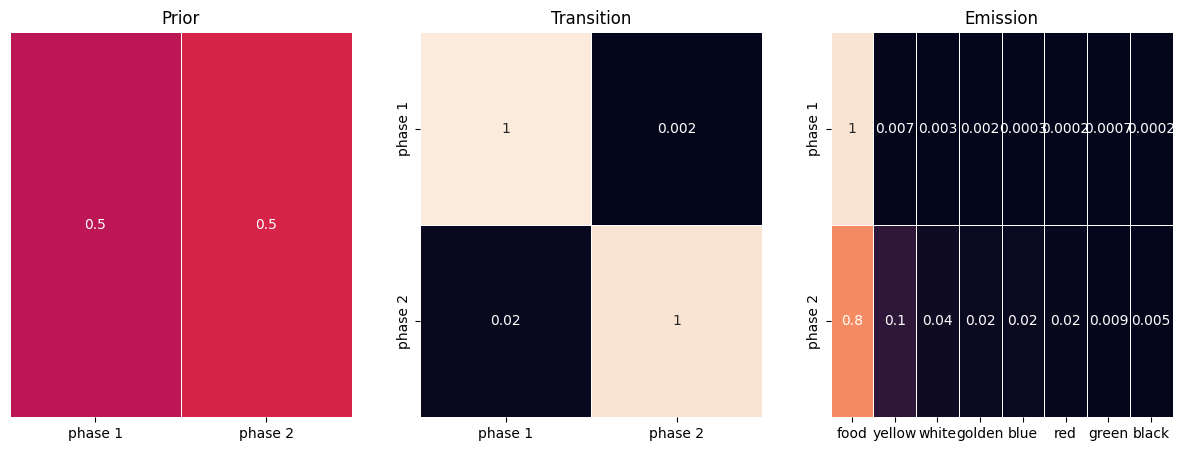

In [94]:
y_labels = ['food', 'yellow', 'white', 'golden', 'blue', 'red', 'green', 'black']
ticks = [0.5, 1.5]
labels = ['phase 1', 'phase 2']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='.1g'
)
sns.heatmap(model_red.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=labels)
sns.heatmap(model_red.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=labels)
ax[1].set_yticks(ticks, labels=labels)
sns.heatmap(model_red.model.emissionprob_[:, :-1], ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=labels)
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_red_best.png')

In [107]:
conf['n_components']=[3]
model_red_3comp = HMMFitter(X_num)
scores = model_red_3comp.fit_model(
    **conf
)

Total data points: 5358, obs states: 9


  0%|                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

Components f3, total parameters: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


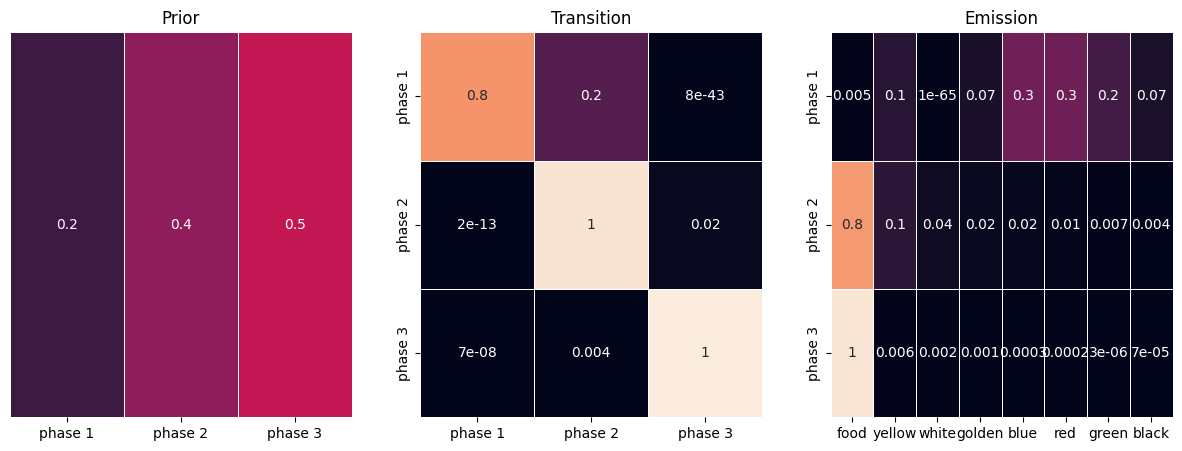

In [108]:
y_labels = ['food', 'yellow', 'white', 'golden', 'blue', 'red', 'green', 'black']
ticks = [0.5, 1.5, 2.5]
labels = ['phase 1', 'phase 2', 'phase 3']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='.1g'
)
sns.heatmap(model_red_3comp.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=labels)
sns.heatmap(model_red_3comp.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=labels)
ax[1].set_yticks(ticks, labels=labels)
sns.heatmap(model_red_3comp.model.emissionprob_[:, :-1], ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=labels)
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_red_3comp.png')

In [117]:
like, X_decoded = model_red_3comp.model.decode(X_num.flatten()[:, None], lengths=[X_num.shape[1]]*X_num.shape[0])
X_decoded = X_decoded.reshape(-1, X_num.shape[1])

In [123]:
X_decoded[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [124]:
X_num[0]

array([0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 8, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## check train for red

In [95]:
red_train, red_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [], sheet=1)
red = pd.concat([red_train, red_test]).reset_index(drop=True)
red_num, color_to_num, freqs = map_colours(red_train, min_count=3, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'белая': 2, 'золотая': 3, 'синяя': 4, 'красная': 5, 'зеленая': 6, 'черная': 7, 'серебряная': 0, 'золотая ': 0}
0             1222
желтая         152
белая           42
золотая         32
синяя           27
красная         22
зеленая         12
черная           7
серебряная       2
золотая          1
Name: count, dtype: int64


/tmp/ipykernel_10403/594870669.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [96]:
X = red_num.to_numpy().astype(np.int32)

In [102]:
model_red_train = HMMFitter(X)
scores = model_red_train.fit_model(
    **conf
)

Total data points: 1520, obs states: 8


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.53it/s]

Components f1, total parameters: 9
Components f2, total parameters: 20


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:06<00:10,  3.52s/it]

Components f3, total parameters: 33


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:15<00:12,  6.45s/it]

Components f4, total parameters: 48


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4/5 [00:29<00:09,  9.30s/it]

Components f5, total parameters: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.89s/it]


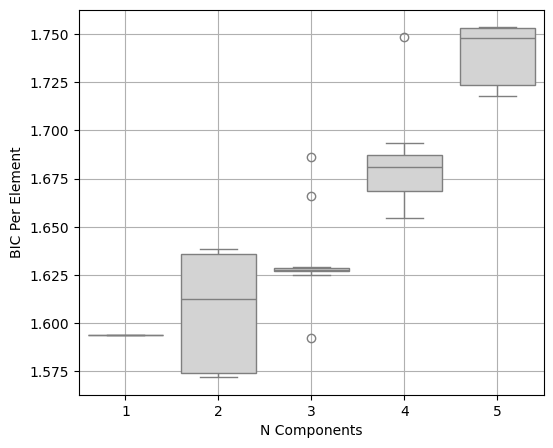

In [103]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(model_red_train.scores, x='n_comp', y='bic', ax=ax, color='lightgray')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_red_train.png')

In [105]:
color_to_num

{0: 0,
 'желтая': 1,
 'белая': 2,
 'золотая': 3,
 'синяя': 4,
 'красная': 5,
 'зеленая': 6,
 'черная': 7,
 'серебряная': 0,
 'золотая ': 0}

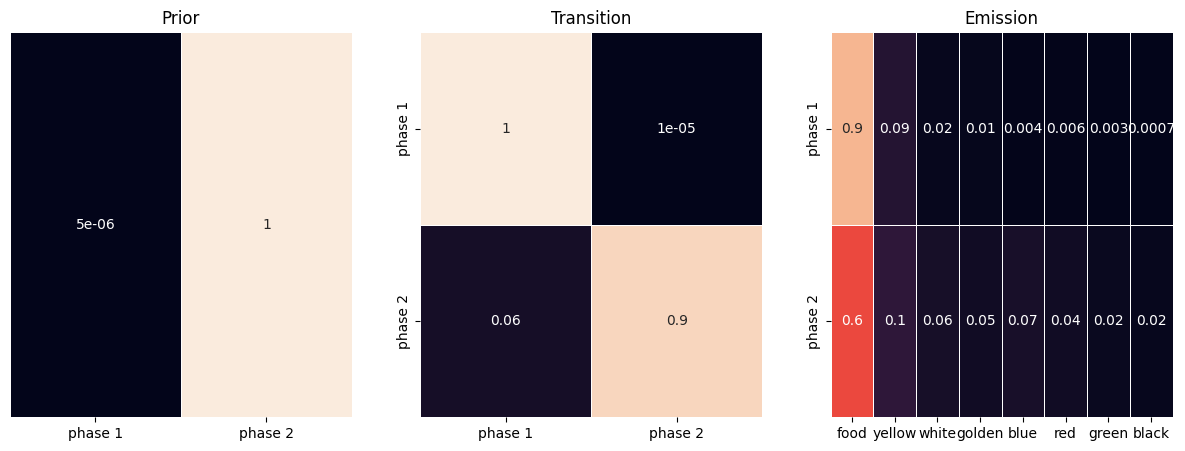

In [106]:
y_labels = ['food', 'yellow', 'white', 'golden', 'blue', 'red', 'green', 'black']
ticks = [0.5, 1.5]
labels = ['phase 1', 'phase 2']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None, fmt='.1g'
)
sns.heatmap(model_red_train.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=labels)
sns.heatmap(model_red_train.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=labels)
ax[1].set_yticks(ticks, labels=labels)
sns.heatmap(model_red_train.model.emissionprob_, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=labels)
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_red_train_best.png')

In [111]:
like, X_decoded = model_red_train.model.decode(X.flatten()[:, None], lengths=[X.shape[1]]*X.shape[0])
X_decoded = X_decoded.reshape(-1, X.shape[1])

In [112]:
X_decoded.shape

(19, 80)

In [115]:
X[0]

array([0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int32)

In [113]:
X_decoded[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
X_decoded[10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])